# DSCI 592: Capstone Project
# Reel Good Movie Recommender System (Group 4)
- By Alireza Hatami

## TF-IDF-Based Content Modeling

### 1. Loading `model_df`

In [ ]:
import os
import time
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from joblib import Parallel, delayed
import joblib
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('./data/cleaned_data.csv')
model_df = pd.read_csv('model_df.csv')

### 2. Vectorizing Textual Data (title, director_clean, actors_clean, overview columns using TFIDF):



In [109]:
def tfidf_and_save(df, column_name, output_prefix, save_dir='./tfidf'):
    """
    Applies TF-IDF to a specific column in the dataframe and saves both
    the resulting sparse matrix and the vectorizer.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): Column to apply TF-IDF on.
        output_prefix (str): Filename prefix (e.g., 'title' → tfidf_title.npz).
        save_dir (str): Folder to save the output files.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Processing TF-IDF for '{column_name}'...")

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df[column_name])

    # Save matrix
    matrix_path = os.path.join(save_dir, f'tfidf_{output_prefix}.npz')
    sparse.save_npz(matrix_path, tfidf_matrix)

    # Save vectorizer
    vectorizer_path = os.path.join(save_dir, f'vectorizer_{output_prefix}.pkl')
    joblib.dump(vectorizer, vectorizer_path)

    print(f"Saved: {matrix_path} and {vectorizer_path} | Shape: {tfidf_matrix.shape}")


In [110]:
tfidf_and_save(model_df, 'title', 'title')

Processing TF-IDF for 'title'...
Saved: ./tfidf\tfidf_title.npz and ./tfidf\vectorizer_title.pkl | Shape: (44880, 45863)


In [111]:
tfidf_and_save(model_df, 'director_clean', 'director')

Processing TF-IDF for 'director_clean'...
Saved: ./tfidf\tfidf_director.npz and ./tfidf\vectorizer_director.pkl | Shape: (44880, 18558)


In [112]:
tfidf_and_save(model_df, 'actors_clean', 'actors')

Processing TF-IDF for 'actors_clean'...
Saved: ./tfidf\tfidf_actors.npz and ./tfidf\vectorizer_actors.pkl | Shape: (44880, 49543)


In [113]:
tfidf_and_save(model_df, 'overview', 'overview')

Processing TF-IDF for 'overview'...
Saved: ./tfidf\tfidf_overview.npz and ./tfidf\vectorizer_overview.pkl | Shape: (44880, 76166)


We can then load the embeddings for use later with:

### 3. Load + Stack Everything Together Later

In [3]:
# Load TF-IDF matrices
tfidf_title = sparse.load_npz('./tfidf/tfidf_title.npz')
tfidf_director = sparse.load_npz('./tfidf/tfidf_director.npz')
tfidf_actors = sparse.load_npz('./tfidf/tfidf_actors.npz')
tfidf_overview = sparse.load_npz('./tfidf/tfidf_overview.npz')

# Load one-hot encodings
language_encoded = pd.read_csv('language_encoded.csv') # From DSCI_592_Additional_Preprocessing.ipynb
genre_df = pd.read_csv('genre_df.csv') # From DSCI_592_Additional_Preprocessing.ipynb

# Convert to sparse
lang_sparse = sparse.csr_matrix(language_encoded.values)
genre_sparse = sparse.csr_matrix(genre_df.values)
year_scaled = sparse.csr_matrix(model_df[['year_scaled']].values)

# Combine everything
final_matrix = sparse.hstack([
    tfidf_title,
    tfidf_director,
    tfidf_actors,
    tfidf_overview,
    genre_sparse,
    lang_sparse,
    year_scaled
])

print("Final matrix shape:", final_matrix.shape)

Final matrix shape: (44880, 190172)


#### 3.1 Saving + Loading the Sparse Matrix

In [7]:
# # Save sparse matrix
# sparse.save_npz('final_matrix_tfidf.npz', final_matrix)

In [5]:
# Load the sparse matrix
final_matrix = sparse.load_npz('final_matrix_tfidf.npz')

### 4. Find Similar Movies:

Here, we:
- Only compute similarity between one movie vs. all others (not all-pairs, which is way too expensive).

- Keep everything sparse.

- Retrieve top N most similar movies (excluding the movie itself).

In [13]:
def get_similar_movies(title, matrix, model_df, top_n=10):
    """
    Finds top N similar movies and returns key metadata.

    Args:
        title (str): Movie title with underscores (e.g., 'Toy_Story').
        matrix (csr_matrix): Sparse feature matrix.
        model_df (pd.DataFrame): DataFrame with movie metadata.
        top_n (int): Number of similar movies to return.

    Returns:
        pd.DataFrame: Top N similar movies with metadata.
    """
    idx = model_df[model_df['title'] == title].index[0]
    sim_scores = cosine_similarity(matrix[idx], matrix).flatten()
    sim_scores[idx] = -1  # Exclude the input movie itself
    
    # sim_scores = -euclidean_distances(matrix[idx], matrix).flatten() # For euclidean distance
    # sim_scores[idx] = np.min(sim_scores) - 1
    
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]

    # Select relevant rows *first*, then assign the score
    result_df = model_df.loc[top_indices, [
        'title', 'director_clean', 'actors_clean', 'genres_clean', 'overview', 'original_language'
    ]].copy()

    result_df['score'] = sim_scores[top_indices]

    result_df['year'] = result_df['title'].apply(
        lambda t: df[df['title'] == t]['year'].values[0] if len(df[df['title'] == t]) > 0 else 'N/A'
    )
    
    return result_df

In [14]:
def print_movie_recommendations(similar_df, max_overview_len=300):
    """
    Pretty prints movie recommendations with director, actors, and a short overview.

    Args:
        similar_df (pd.DataFrame): DataFrame from get_similar_movies().
        max_overview_len (int): Max number of characters to show for overview.
    """   
    for i, row in similar_df.iterrows():
        print(f"{row['title']} ({row['year']}) — Score: {row['score']:.4f}")
        print(f"   Director: {row['director_clean']}")
        print(f"   Actors: {row['actors_clean']}")
        print(f"   Genres: {row['genres_clean']}")
        print(f"   Overview: {row['overview'][:max_overview_len]}...\n")
        print("-"*60)

In [15]:
similar = get_similar_movies('Toy Story', final_matrix, model_df, top_n=10)
print_movie_recommendations(similar)

Toy Story 2 (1999) — Score: 0.7789
   Director: John_Lasseter
   Actors: Tom_Hanks Tim_Allen Joan_Cusack
   Genres: ['Animation', 'Comedy', 'Family']
   Overview: Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and h...

------------------------------------------------------------
Toy Story 3 (2010) — Score: 0.6744
   Director: Lee_Unkrich
   Actors: Tom_Hanks Tim_Allen Ned_Beatty
   Genres: ['Animation', 'Family', 'Comedy']
   Overview: Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally left at a nefarious day care center. The toys must band together to escape and return home to Andy....

-----------------------------------------------------------

In [16]:
similar_matrix = get_similar_movies('The Matrix', final_matrix, model_df, top_n=10)
print_movie_recommendations(similar_matrix)

The Matrix Reloaded (2003) — Score: 0.6050
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Carrie-Anne_Moss Laurence_Fishburne
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: Six months after the events depicted in The Matrix, Neo has proved to be a good omen for the free humans, as more and more humans are being freed from the matrix and brought to Zion, the one and only stronghold of the Resistance.  Neo himself has discovered his superpowers including super speed, abi...

------------------------------------------------------------
The Matrix Revolutions (2003) — Score: 0.5933
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Laurence_Fishburne Carrie-Anne_Moss
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: The human city of Zion defends itself against the massive invasion of the machines as Neo fights to end the war at another front while also opposing the rogue Agent Smith....

---------------------------

In [17]:
similar_Home_Alone = get_similar_movies('Home Alone', final_matrix, model_df, top_n=10)
print_movie_recommendations(similar_Home_Alone)

Home Alone 2: Lost in New York (1992) — Score: 0.6307
   Director: Chris_Columbus
   Actors: Macaulay_Culkin Joe_Pesci Catherine_O'Hara
   Genres: ['Comedy', 'Family', 'Adventure', 'Crime']
   Overview: Instead of flying to Florida with his folks, Kevin ends up alone in New York, where he gets a hotel room with his dad's credit card—despite problems from a clerk and meddling bellboy. But when Kevin runs into his old nemeses, the Wet Bandits, he's determined to foil their plans to rob a toy store on...

------------------------------------------------------------
Mrs. Doubtfire (1993) — Score: 0.5716
   Director: Chris_Columbus
   Actors: Robin_Williams Sally_Field Pierce_Brosnan
   Genres: ['Comedy', 'Drama', 'Family']
   Overview: Loving but irresponsible dad Daniel Hillard, estranged from his exasperated spouse, is crushed by a court order allowing only weekly visits with his kids. When Daniel learns his ex needs a housekeeper, he gets the job -- disguised as an English nanny. Soon h

### 5. Performance Evaluation

We built item-to-item content-based filtering, where we measure similarity between movies based on their metadata and content (e.g., title, genres, actors, etc.), and recommend similar movies to a given movie. This is one valid form of content-based recommendation, especially useful when:
- We have no or minimal user interaction data
- We want to support queries like “Show me movies like Toy Story”

#### 5.1. `is_relevant()` Function

In [10]:
def is_relevant(query_row, candidate_row):
    # 1. Language must match
    if query_row['original_language'] != candidate_row['original_language']:
        return False

    # 2. Director match
    if query_row['director_clean'] == candidate_row['director_clean']:
        return True

    # 3. At least 2 genres match
    query_genres = set(eval(query_row['genres_clean']))
    candidate_genres = set(eval(candidate_row['genres_clean']))
    if len(query_genres.intersection(candidate_genres)) >= 2:
        return True

    # 4. At least 1 actor match
    query_actors = set(query_row['actors_clean'].split())
    candidate_actors = set(candidate_row['actors_clean'].split())
    if len(query_actors.intersection(candidate_actors)) >= 1:
        return True

    # None matched
    return False

#### 5.2. Calculating `Precision@K`

How many of the top-K recommended movies are actually relevant?

In [11]:
def precision_at_k(query_title, model_df, matrix, k=10):
    """
    Computes Precision@K for a given movie by comparing its top K similar movies
    against a relevance function.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): DataFrame containing movie metadata.
        matrix (csr_matrix): Sparse matrix of movie feature vectors.
        k (int): Number of top recommendations to consider (default is 10).

    Returns:
        float: Precision@K score, i.e., the proportion of top K recommendations
               that are considered relevant.
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    relevant_count = 0
    for _, candidate_row in recommended.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_count += 1

    precision = relevant_count / k
    return precision

#### 5.3. Calculating `Recall@K`

Out of all relevant movies in the full catalog, how many were retrieved in top K?

In [12]:
def recall_at_k(query_title, model_df, matrix, k=10):
    """
    Computes Recall@K for a given movie by comparing its top K similar movies
    against the full set of relevant movies in the dataset.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): DataFrame containing movie metadata.
        matrix (csr_matrix): Sparse matrix of movie feature vectors.
        k (int): Number of top recommendations to consider (default is 10).

    Returns:
        float: Recall@K score, i.e., the proportion of all relevant movies
               that appear in the top K recommendations.
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    # Find all relevant movies in dataset
    relevant_total = 0
    for _, candidate_row in model_df.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_total += 1

    # Prevent division by zero
    if relevant_total == 0:
        return 0.0

    # Get top-k recommended
    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    relevant_in_topk = 0
    for _, candidate_row in recommended.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_in_topk += 1

    recall = relevant_in_topk / relevant_total
    return recall

#### 5.4. `MRR@K (Mean Reciprocal Rank)`

"How early did I show the user something they liked?"

In [13]:
def mrr_at_k(query_title, model_df, matrix, k=10):
    """
    Computes the Mean Reciprocal Rank at K (MRR@K) for a given query movie.

    MRR@K measures how early the first relevant item appears in the top K
    recommendations. It returns the reciprocal of the rank of the first 
    relevant recommendation, or 0 if no relevant item is found.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): DataFrame containing movie metadata.
        matrix (csr_matrix): Sparse matrix of movie feature vectors.
        k (int): Number of top recommendations to consider (default is 10).

    Returns:
        float: Reciprocal rank of the first relevant recommendation, or 0.0
               if no relevant item is found in the top K.
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    for rank, (_, candidate_row) in enumerate(recommended.iterrows(), start=1):
        if is_relevant(query_row, candidate_row):
            return 1 / rank  # Reciprocal Rank

    return 0.0  # No relevant item found

#### 5.5. `evaluate_multiple_queries()`

In [14]:
import random

def evaluate_multiple_queries(model_df, matrix, num_samples=100, k=10, seed=42):
    """
    Evaluates the performance of a recommendation system over multiple randomly 
    selected query movies using Precision@K, Recall@K, and MRR@K metrics.

    Args:
        model_df (pd.DataFrame): DataFrame containing movie metadata.
        matrix (csr_matrix): Sparse matrix of movie feature vectors used for similarity computation.
        num_samples (int): Number of random movies to sample for evaluation (default is 100).
        k (int): Number of top recommendations to consider for each metric (default is 10).
        seed (int): Random seed for reproducibility (default is 42).

    Returns:
        tuple: A tuple containing:
            - mean_precision (float): Mean Precision@K over all valid samples.
            - mean_recall (float): Mean Recall@K over all valid samples.
            - mean_mrr (float): Mean Mean Reciprocal Rank@K over all valid samples.
    
    Notes:
        - Movies that raise errors during evaluation (e.g., missing data) are skipped.
        - Metrics are averaged only over successfully evaluated samples.
    """
    
    random.seed(seed)  # for reproducibility

    # Randomly pick num_samples titles
    sample_titles = random.sample(list(model_df['title']), num_samples)

    precisions = []
    recalls = []
    mrrs = []

    for title in sample_titles:
        try:
            precision = precision_at_k(title, model_df, matrix, k)
            recall = recall_at_k(title, model_df, matrix, k)
            mrr = mrr_at_k(title, model_df, matrix, k)

            precisions.append(precision)
            recalls.append(recall)
            mrrs.append(mrr)
        
        except Exception as e:
            print(f"Skipping '{title}' due to error: {e}")
            continue

    # Calculate means
    mean_precision = sum(precisions) / len(precisions) if precisions else 0
    mean_recall = sum(recalls) / len(recalls) if recalls else 0
    mean_mrr = sum(mrrs) / len(mrrs) if mrrs else 0

    print(f"\nEvaluation Results over {len(precisions)} movies:")
    print(f"➡Mean Precision@{k}: {mean_precision:.4f}")
    print(f"➡Mean Recall@{k}: {mean_recall:.4f}")
    print(f"➡Mean MRR@{k}: {mean_mrr:.4f}")

    return mean_precision, mean_recall, mean_mrr

##### 5.5.1 Evaluatation `@5`, `@10` and `@20` using Cosine Similarity

In [16]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.8120
➡Mean Recall@5: 0.0820
➡Mean MRR@5: 0.9137


In [23]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.7710
➡Mean Recall@10: 0.1063
➡Mean MRR@10: 0.9137


In [17]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.7235
➡Mean Recall@20: 0.1293
➡Mean MRR@20: 0.9137


##### 5.5.2 Evaluatation `@5`, `@10` and `@20` using Euclidean Disance

In [15]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7500
➡Mean Recall@5: 0.0609
➡Mean MRR@5: 0.8320


In [16]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.7280
➡Mean Recall@10: 0.0824
➡Mean MRR@10: 0.8374


In [17]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_matrix, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.7030
➡Mean Recall@20: 0.1069
➡Mean MRR@20: 0.8387


**Observation**

Cosine Work Better for TF-IDF, why?

- Cosine is designed to measure angle/direction, not magnitude — perfect for normalized sparse vectors
- Magnitude is not meaningful in TF-IDF
- Euclidean penalizes documents that are longer or shorter, even if the word composition is similar

So, Cosine similarity is significantly more effective than Euclidean distance for TF-IDF-based movie recommendation, especially for ranking relevant items early (as shown by higher MRR, Precision, and Recall).

In [21]:
# Summary of the Results
k_values = [5, 10, 20]

cosine_metrics_tfidf = {
    'P': [0.8120, 0.7710, 0.7235],
    'R': [0.0820, 0.1063, 0.1293],
    'MRR': [0.9137, 0.9137, 0.9137]
}

euclidean_metrics_tfidf = {
    'P': [0.7500, 0.7280, 0.7030],
    'R': [0.0609, 0.0824, 0.1069],
    'MRR': [0.8320, 0.8374, 0.8387]
}

In [19]:
def plot_comparison(cosine_metrics, euclidean_metrics, k_values):
    """
    Plot side-by-side comparison of Precision@K, Recall@K, and MRR@K
    between cosine similarity and Euclidean distance.

    Parameters:
    -----------
    cosine_metrics : dict
        Dictionary containing 'P', 'R', and 'MRR' scores for each K using cosine similarity.
        Example: {'P': [...], 'R': [...], 'MRR': [...]}

    euclidean_metrics : dict
        Dictionary containing 'P', 'R', and 'MRR' scores for each K using Euclidean distance.
        Example: {'P': [...], 'R': [...], 'MRR': [...]}

    k_values : list of int
        List of K values used for evaluation (e.g., [5, 10, 20]).

    Returns:
    --------
    None
        Displays a matplotlib figure with 3 subplots comparing the metrics.
    """
    
    metrics = ['P', 'R', 'MRR']
    labels = ['Precision@K', 'Recall@K', 'MRR@K']
    
    plt.figure(figsize=(12, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(k_values, cosine_metrics[metric], marker='o', label='Cosine')
        plt.plot(k_values, euclidean_metrics[metric], marker='s', label='Euclidean')
        plt.title(labels[i])
        plt.xlabel('K')
        plt.ylabel('Score')
        plt.xticks(k_values)
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

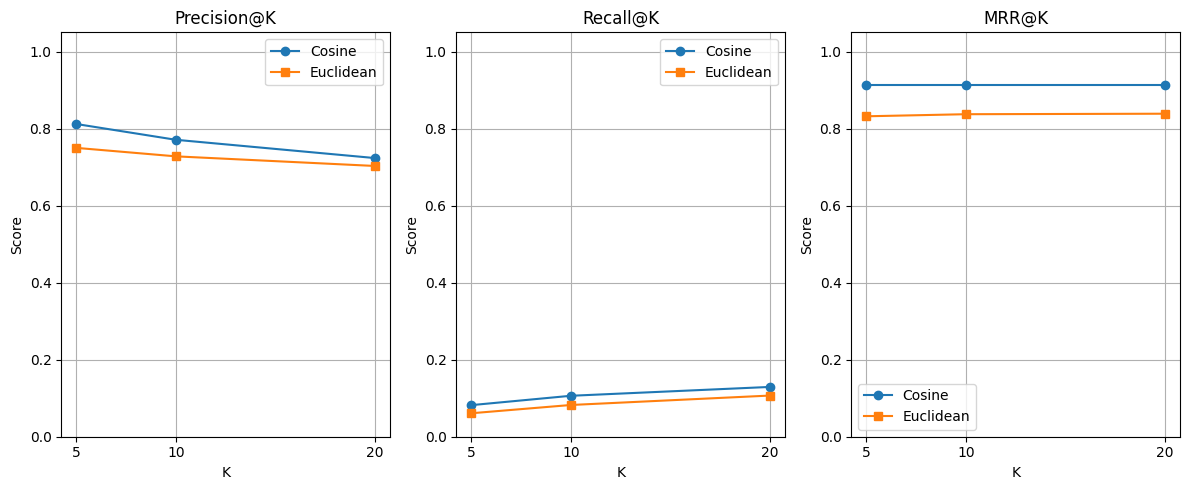

In [22]:
plot_comparison(cosine_metrics_tfidf, euclidean_metrics_tfidf, k_values)

Since we have 45000 movies, it will take a lot of computational power to calculate precision on every single item (we have about 45000 movies). So, the strategy to evaluate all movies includes:

1. Batch Processing: Split the movie dataset into manageable chunks (e.g., 100–500 movies per batch) and process each batch independently.
2. Caching Expensive Computations: Reuse similarity vectors instead of re-computing. If you’re always calculating similarity between a single movie and all others, keep the sparse matrix in memory, and slice once per iteration.
3. Avoid DataFrame Iteration
4. Instead of iterating rows with `.iterrows()`, vectorize operations wherever possible or minimize expensive loops.
5. Use `joblib.Parallel` to Leverage All CPU Cores: This significantly reduces compute time.

In [7]:
# CONFIG
BATCH_SIZE = 100
TOP_K = 10
SAVE_PATH = "evaluation_precision_mrr.csv"

# Load data
model_df = pd.read_csv("model_df.csv")  # Already preprocessed
final_matrix = sparse.load_npz("final_matrix_tfidf.npz")

# Load genres and language one-hots if needed
if 'original_language' not in model_df.columns:
    model_df['original_language'] = pd.read_csv("language_encoded.csv").idxmax(axis=1)

# is_relevant function (without recall dependency)
def is_relevant(query_row, candidate_row):
    """
    Determines if a candidate movie is relevant to a query movie based on shared metadata.

    Relevance is defined by the following conditions:
    - Must have the same original language.
    - OR same director.
    - OR at least two shared genres.
    - OR at least one shared actor.

    Parameters:
    -----------
    query_row : pd.Series
        Metadata for the query movie.

    candidate_row : pd.Series
        Metadata for the candidate movie.

    Returns:
    --------
    bool
        True if the candidate is relevant to the query, False otherwise.
    """
    
    if query_row['original_language'] != candidate_row['original_language']:
        return False
    if query_row['director_clean'] == candidate_row['director_clean']:
        return True
    query_genres = set(eval(query_row['genres_clean'])) if isinstance(query_row['genres_clean'], str) else set()
    candidate_genres = set(eval(candidate_row['genres_clean'])) if isinstance(candidate_row['genres_clean'], str) else set()
    if len(query_genres.intersection(candidate_genres)) >= 2:
        return True
    query_actors = set(query_row['actors_clean'].split())
    candidate_actors = set(candidate_row['actors_clean'].split())
    if len(query_actors.intersection(candidate_actors)) >= 1:
        return True
    return False

def evaluate_one_movie(i):
    """
    Computes Precision@K and MRR@K for a single movie based on cosine similarity.

    Parameters:
    -----------
    i : int
        Index of the query movie in the TF-IDF matrix.

    Returns:
    --------
    tuple
        (movie_index, movie_title, precision@K, mrr@K)
        or (movie_index, movie_title, None, None) if an error occurs.
    """
    
    try:
        query_vec = final_matrix[i]
        sims = cosine_similarity(query_vec, final_matrix).flatten()
        sims[i] = -1  # exclude itself
        top_indices = np.argsort(sims)[-TOP_K:][::-1]
        query_row = model_df.iloc[i]
        relevant_found = 0
        reciprocal_rank = 0.0

        for rank, idx in enumerate(top_indices, start=1):
            candidate_row = model_df.iloc[idx]
            if is_relevant(query_row, candidate_row):
                relevant_found += 1
                if reciprocal_rank == 0.0:
                    reciprocal_rank = 1 / rank

        precision = relevant_found / TOP_K
        return i, model_df.iloc[i]['title'], precision, reciprocal_rank

    except Exception as e:
        return i, model_df.iloc[i]['title'], None, None

def save_batch_results(batch_results, filepath):
    """
    Appends a batch of evaluation results to a CSV file.

    Parameters:
    -----------
    batch_results : list of tuples
        Each tuple contains (index, title, precision@K, mrr@K).

    filepath : str
        Path to the CSV file where results will be saved.

    Returns:
    --------
    None
    """
    
    df = pd.DataFrame(batch_results, columns=["index", "title", f"precision@{TOP_K}", f"mrr@{TOP_K}"])
    if os.path.exists(filepath):
        df.to_csv(filepath, mode='a', header=False, index=False)
    else:
        df.to_csv(filepath, index=False)

# Check already processed indices
if os.path.exists(SAVE_PATH):
    existing = pd.read_csv(SAVE_PATH)
    processed_indices = set(existing['index'])
else:
    processed_indices = set()

# Batch loop
total_movies = len(model_df)
for start in range(0, total_movies, BATCH_SIZE):
    end = min(start + BATCH_SIZE, total_movies)
    batch_indices = [i for i in range(start, end) if i not in processed_indices]

    if not batch_indices:
        print(f"Skipping batch {start}–{end}, already done.")
        continue

    print(f"Processing movies {start} to {end}...")
    start_time = time.time()

    batch_results = Parallel(n_jobs=-1)(
        delayed(evaluate_one_movie)(i) for i in batch_indices
    )

    batch_results = [res for res in batch_results if res[2] is not None]  # Filter failed ones
    save_batch_results(batch_results, SAVE_PATH)

    print(f"Saved batch {start}–{end} in {time.time() - start_time:.1f} sec. Total done: {start + len(batch_results)}")

print("\nAll batches completed. Results saved to:", SAVE_PATH)

Processing movies 0 to 100...
Saved batch 0–100 in 20.4 sec. Total done: 100
Processing movies 100 to 200...
Saved batch 100–200 in 17.3 sec. Total done: 200
Processing movies 200 to 300...
Saved batch 200–300 in 18.2 sec. Total done: 300
Processing movies 300 to 400...
Saved batch 300–400 in 16.5 sec. Total done: 400
Processing movies 400 to 500...
Saved batch 400–500 in 16.2 sec. Total done: 500
Processing movies 500 to 600...
Saved batch 500–600 in 17.0 sec. Total done: 600
Processing movies 600 to 700...
Saved batch 600–700 in 16.1 sec. Total done: 700
Processing movies 700 to 800...
Saved batch 700–800 in 17.7 sec. Total done: 800
Processing movies 800 to 900...
Saved batch 800–900 in 16.9 sec. Total done: 900
Processing movies 900 to 1000...
Saved batch 900–1000 in 17.6 sec. Total done: 1000
Processing movies 1000 to 1100...
Saved batch 1000–1100 in 17.4 sec. Total done: 1100
Processing movies 1100 to 1200...
Saved batch 1100–1200 in 17.1 sec. Total done: 1200
Processing movies 1

**Notes:**
- You can pause and resume the script anytime. It skips already processed indices.
- If you want to test quickly, try `BATCH_SIZE = 10`.
- You can adjust `TOP_K = 5` or `20` easily.

The code above:
- `delayed(...)` wraps that function so it can be executed in parallel.

`Parallel(n_jobs=-1)` tells it to:
- Use all available CPU cores on our machine (based on the number of threads available on a laptop or pc).
- Distribute the evaluation across those cores automatically.

In [8]:
# Calculate Final Averages on Precision and MRR

# Load your results
results = pd.read_csv("evaluation_precision_mrr.csv")

# Drop any incomplete or failed entries (optional safety)
results = results.dropna(subset=["precision@10", "mrr@10"])

# Compute the averages
mean_precision = results["precision@10"].mean()
mean_mrr = results["mrr@10"].mean()

print(f"Final Evaluation over {len(results)} movies:")
print(f"Mean Precision@10: {mean_precision:.4f}")
print(f"Mean MRR@10: {mean_mrr:.4f}")

Final Evaluation over 44880 movies:
Mean Precision@10: 0.7796
Mean MRR@10: 0.9016


-----------------

### 6. Performance Evaluation (User-Profile-Based Recommendation Evaluation)

This evaluation method is not our primary objective, and it is merely experimental because evaluation using this approach usually requires a massive database of users' ratings to capture each user's preference and make a user profile. However, it is impossible for each user to see and record enough movie ratings to fulfill the requirement of such an evaluation successfully. To address this issue, scientists offered matrix factorization as a very effective method to replace this approach.

Recommending items to a customer similar to previous items rated highly by the customer. Based on the items a user likes, we can create a profile to suggest similar movies they may enjoy. So, we need to create a profile for items as well (or a vector of features), which has already been done using the TF-IDF Vectorizer. After making an item's profile, we need to create a user profile. A user profile is an aggregate of items, like a weighted average of rated item profiles. Having both the item profile and the user profile will allow us to estimate the similarity of vectors between the user profile and the item profile.


**Issues with this approach:**
- **Over Specialization**
  - It never suggests items outside of users' preferences
  - People might have multiple interests, and limited knowledge of users' taste (of movies they have rated) is not enough to capture their preferences.
  - Unlike the collaborative filtering approach, we are unable to benefit from the quality judgments of other users
- **New Users**
   - How can we build a user profile for new users?
   - That is why we need the previous approach (only based on item profiles), where we can suggest items based on the content of other items.
   - For instance, when you join Netflix, it asks you to pick three movies or series that you like; otherwise, you cannot skip the page.

#### 6.1. Building User Profiles

Here, we create a personalized vector for each user using the ratings they gave to movies, a weighted average of the corresponding item feature vectors. The code below:
- Lops over each user.
- Builds a normalized user profile vector.
- Saves it as user_{user_id}.npz in a folder.

In [ ]:
# Load data
model_df = pd.read_csv('./data/model_ready_movie_data.csv')
final_matrix = sparse.load_npz('final_matrix_tfidf.npz')
# Load full ratings dataset
ratings = pd.read_csv('./data/filtered_ratings.csv')

# Count how many ratings each user has
user_counts = ratings['userId'].value_counts()

# Keep only users with at least 200 ratings (Because we want enough movies with diverse ratings to be available)
eligible_users = user_counts[user_counts >= 200].index

# Filter ratings dataframe to include only those users
ratings = ratings[ratings['userId'].isin(eligible_users)]

# Make sure 'id' is available
model_df['id'] = df['id']
ratings['movieId'] = ratings['movieId'].astype(int)

In [7]:
# Build mapping from movie ID to index in final_matrix
movie_id_to_index = {mid: idx for idx, mid in enumerate(model_df['id'])}

# Output directory to save user profiles
os.makedirs('./user_profiles200', exist_ok=True)

def build_user_profile(user_ratings):
    """
    Build a sparse user profile vector as a weighted average of item vectors,
    using all ratings (positive and negative).
    """
    indices = [movie_id_to_index.get(mid) for mid in user_ratings['movieId'] if mid in movie_id_to_index]

    if not indices:
        return None

    vectors = final_matrix[indices]
    ratings = user_ratings['rating'].values[:len(indices)]

    # Weighted sum of vectors
    weighted_vectors = vectors.multiply(ratings[:, np.newaxis])
    profile_vector = weighted_vectors.sum(axis=0)

    # Convert np.matrix to sparse CSR matrix
    profile_vector = sparse.csr_matrix(profile_vector)

    # Normalize
    profile_vector = normalize(profile_vector)

    return profile_vector

# Process and save each user
unique_users = ratings['userId'].unique()

for user_id in tqdm(unique_users, desc="Building user profiles"):
    user_ratings = ratings[ratings['userId'] == user_id]
    user_vector = build_user_profile(user_ratings)

    if user_vector is not None:
        sparse.save_npz(f'./user_profiles/user_{user_id}.npz', user_vector)

Building user profiles: 100%|██████████| 10277/10277 [04:42<00:00, 36.37it/s]


#### 6.3. Generating Recommendations + Evaluating (Precision@K and MRR@K)

So, for each user, we follow these steps:
1. Split their ratings into train/test (e.g. 80/20).
2. Build user profile from training ratings (already done).
3. Predict similarity scores between the user profile and each test movie.
4. Rank test items by similarity.

5. Evaluate:
  - Precision@K: Proportion of top-K movies rated ≥ 4
  - MRR@K: Reciprocal rank of the first relevant (rated ≥ 4) item in top-K

#### 6.4. Per-User Train/Test Split

We’ll split each user’s ratings into:
- Training set (80%) → used to build profile (already done)
- Test set (20%) → used for evaluation

To compute Precision@K and MRR@K meaningfully for values like K = 5, 10, 20, we must ensure that each user's test set has at least 30 relevant (rating ≥ 4.0) items.

In [20]:
RELEVANT_RATING = 4.0
MIN_RELEVANT_IN_TEST = 30

user_train_test_split = {}

for user_id in tqdm(ratings['userId'].unique(), desc="Splitting ratings"):
    user_data = ratings[ratings['userId'] == user_id].sort_values('timestamp')

    if len(user_data) < 50:
        continue  # basic total check

    # 80/20 split
    train, test = train_test_split(user_data, test_size=0.2, random_state=42)

    # We keep the entire test set (mixed ratings)
    # But include users with ≥ 30 relevant items in test set
    if (test['rating'] >= RELEVANT_RATING).sum() >= MIN_RELEVANT_IN_TEST:
        user_train_test_split[user_id] = (train, test)

Splitting ratings: 100%|██████████| 10277/10277 [00:53<00:00, 191.10it/s]


#### 6.5. Scoring Test Items Using Cosine Similarity

Use each user's saved profile to score all items in their test set via cosine similarity, then rank them.

So, we get ranked recommendations for a user:

In [11]:
def get_user_recommendation_scores(user_id, test_df):
    """
    Given a user's ID and their test ratings, return:
    - test movie indices
    - scores from cosine similarity
    - actual ratings
    """
    profile_path = f'./user_profiles200/user_{user_id}.npz'
    if not os.path.exists(profile_path):
        return None  # skip users with no profile

    user_vector = sparse.load_npz(profile_path)

    # Get item indices in the test set
    valid_rows = []
    actual_ratings = []

    for _, row in test_df.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        if movie_id in movie_id_to_index:
            idx = movie_id_to_index[movie_id]
            valid_rows.append(idx)
            actual_ratings.append(rating)

    if not valid_rows:
        return None

    test_vectors = final_matrix[valid_rows]
    scores = cosine_similarity(user_vector, test_vectors).flatten()

    return list(zip(valid_rows, scores, actual_ratings))

#### 6.6. Compute Precision@K and MRR@K

**Precision@K:**
- Proportion of top-K recommended movies that have actual rating ≥ 4.0.

**MRR@K (Mean Reciprocal Rank):**
- 1 / rank of the first relevant (rating ≥ 4.0) item among top K, or 0 if none.

In [13]:
def evaluate_precision_mrr_k(recommendations, k, relevant_threshold=4.0):
    """
    recommendations: list of (movie_idx, score, actual_rating), sorted by score DESC
    Returns: precision@k, mrr@k
    """
    top_k = recommendations[:k]
    relevant_flags = [rating >= relevant_threshold for _, _, rating in top_k]

    # Precision@K
    precision = sum(relevant_flags) / k

    # MRR@K
    mrr = 0
    for rank, is_relevant in enumerate(relevant_flags, start=1):
        if is_relevant:
            mrr = 1.0 / rank
            break

    return precision, mrr

#### 6.7. Evaluate Across All Users

Now, we evaluate across all users. This code:

- Loads the test set for each user
- Loads their profile vector
- Ranks test items by similarity
- Computes Precision@5/10/20 and MRR@5/10/20
- Averages them across users

In [21]:
# Initialize lists to store evaluation metrics for each user
precision_at_5 = []
precision_at_10 = []
precision_at_20 = []

mrr_at_5 = []
mrr_at_10 = []
mrr_at_20 = []

# Iterate over each user and their corresponding test set
for user_id, (_, test_df) in tqdm(user_train_test_split.items(), desc="Evaluating users"):

    # Get similarity scores between the user profile and each movie in the user's test set
    scores = get_user_recommendation_scores(user_id, test_df)
    
    if not scores:
        continue  # skip users with no test items

    # Sort test items by similarity score in descending order
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)

    # Evaluate Precision@K and MRR@K for K = 5, 10, 20
    p5, mrr5 = evaluate_precision_mrr_k(ranked, k=5)
    p10, mrr10 = evaluate_precision_mrr_k(ranked, k=10)
    p20, mrr20 = evaluate_precision_mrr_k(ranked, k=20)

    precision_at_5.append(p5)
    precision_at_10.append(p10)
    precision_at_20.append(p20)

    mrr_at_5.append(mrr5)
    mrr_at_10.append(mrr10)
    mrr_at_20.append(mrr20)

Evaluating users: 100%|██████████| 3989/3989 [00:31<00:00, 125.70it/s]


In [22]:
print("Evaluation Results:")
print(f"Precision@5:  {np.mean(precision_at_5):.4f}")
print(f"Precision@10: {np.mean(precision_at_10):.4f}")
print(f"Precision@20: {np.mean(precision_at_20):.4f}")

print(f"MRR@5:        {np.mean(mrr_at_5):.4f}")
print(f"MRR@10:       {np.mean(mrr_at_10):.4f}")
print(f"MRR@20:       {np.mean(mrr_at_20):.4f}")

Evaluation Results:
Precision@5:  0.5994
Precision@10: 0.5837
Precision@20: 0.5796
MRR@5:        0.7624
MRR@10:       0.7656
MRR@20:       0.7658
